## **1.Subtask 1 - Polarization detection**


### **1.1 Imports**

In [1]:
#!unzip dev_phase.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install iterative-stratification

In [4]:
!pip install -qq optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import random
from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

import os
import zipfile
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
!pip install -q nltk
!pip install -q transformers sentencepiece
from transformers import MarianMTModel, MarianTokenizer
import math

In [7]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


In [8]:
from transformers import set_seed
def set_global_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, NumPy, PyTorch, and Hugging Face Transformers.

    Args:
        seed (int): Seed value to use.
    """


    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # CUDNN settings for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hugging Face Transformers
    set_seed(seed)

    print(f"[INFO] Global seed set to {seed}")


In [9]:
set_global_seed(42)

[INFO] Global seed set to 42


### 1.2 **Data Import**

In [10]:
# Load the training and validation data for subtask 1
train_eng_all = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/eng.csv')
train_hau_all = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/hau.csv')



#### **Data Augmentation Functions**

##### **English**

In [11]:
# English -> French
en_fr_model_name = 'Helsinki-NLP/opus-mt-en-fr'
en_fr_tokenizer = MarianTokenizer.from_pretrained(en_fr_model_name)
en_fr_model = MarianMTModel.from_pretrained(en_fr_model_name)

# French -> English
fr_en_model_name = 'Helsinki-NLP/opus-mt-fr-en'
fr_en_tokenizer = MarianTokenizer.from_pretrained(fr_en_model_name)
fr_en_model = MarianMTModel.from_pretrained(fr_en_model_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
en_fr_model.to(device)
fr_en_model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [12]:

def translate(texts, model, tokenizer, device='cpu', max_length=128):
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated = model.generate(**batch, max_length=max_length)
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    return translated_texts


def back_translate_en(texts, device='cpu'):
    # English -> French -> English
    fr_texts = translate(texts, en_fr_model, en_fr_tokenizer, device=device)
    back_translated_texts = translate(fr_texts, fr_en_model, fr_en_tokenizer, device=device)
    return back_translated_texts

In [13]:
def augment_minority_backtranslation_batch(df, text_col='text', label_col='polarization',
                                           translate_fn=None, device='cpu', n_augments=3,
                                           batch_size=16, shuffle=True, lang='English'):
    """
    Augment minority class using batch back-translation for multiple samples per sentence.
    """
    # Detect minority class
    minority_label = df[label_col].value_counts().idxmin()
    minority_class = df[df[label_col] == minority_label].copy()

    augmented_rows = []
    texts = minority_class[text_col].tolist()
    total_batches = math.ceil(len(texts) / batch_size)

    desc_text = f"Back-translating minority class (batch): {lang}"
    for batch_idx in tqdm(range(total_batches), desc=desc_text):
        batch_texts = texts[batch_idx*batch_size:(batch_idx+1)*batch_size]
        for _ in range(n_augments):
            augmented_texts = translate_fn(batch_texts, device=device)
            for i, aug_text in enumerate(augmented_texts):
                new_row = minority_class.iloc[batch_idx*batch_size + i].copy()
                new_row[text_col] = aug_text
                augmented_rows.append(new_row)

    augmented_df = pd.DataFrame(augmented_rows)

    # Append to original dataframe
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)

    if shuffle:
        df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_augmented

##### **Hausa**

In [14]:

# Hausa -> English
ha_en_model_name = 'Helsinki-NLP/opus-mt-ha-en'
ha_en_tokenizer = MarianTokenizer.from_pretrained(ha_en_model_name)
ha_en_model = MarianMTModel.from_pretrained(ha_en_model_name)

# English -> Hausa
en_ha_model_name = 'Helsinki-NLP/opus-mt-en-ha'
en_ha_tokenizer = MarianTokenizer.from_pretrained(en_ha_model_name)
en_ha_model = MarianMTModel.from_pretrained(en_ha_model_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ha_en_model.to(device)
en_ha_model.to(device)



tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58089, 512, padding_idx=58088)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58089, 512, padding_idx=58088)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [15]:
def back_translate_hausa(texts, device='cpu'):
    # Hausa -> English
    english_texts = translate(texts, ha_en_model, ha_en_tokenizer, device=device)
    # English -> Hausa
    back_translated_texts = translate(english_texts, en_ha_model, en_ha_tokenizer, device=device)
    return back_translated_texts


In [16]:

def back_translate_batch(texts, translate_fn, device='cpu', batch_size=16):
    """
    Back-translate a list of texts in batches.

    Args:
        texts (list): List of input sentences.
        translate_fn (callable): Translation function that accepts a list of texts.
        device (str): 'cpu' or 'cuda'.
        batch_size (int): Number of sentences to process per batch.

    Returns:
        list: Back-translated texts.
    """
    augmented_texts = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Back-translating batches"):
        batch = texts[i:i+batch_size]
        back_translated_batch = translate_fn(batch, device=device)
        augmented_texts.extend(back_translated_batch)
    return augmented_texts


#### **Data Train Split and Augumentation**

In [17]:
train_eng_org, val_eng = train_test_split(
    train_eng_all,
    test_size=0.1,
    shuffle=True,
    stratify=train_eng_all['polarization'],
    random_state=40
)

train_hau_org, val_hau = train_test_split(
    train_hau_all,
    test_size=0.1,
    shuffle=True,
    stratify=train_hau_all['polarization'],
    random_state=40
)

# English back-translation augmentation
train_eng = augment_minority_backtranslation_batch(
    train_eng_org,
    text_col='text',
    label_col='polarization',
    translate_fn=back_translate_en,
    device=device,
    n_augments=3,   # number of augmented versions per sentence
    batch_size=16,
    lang='English'
)

# Hausa back-translation augmentation
train_hau = augment_minority_backtranslation_batch(
    train_hau_org,
    text_col='text',
    label_col='polarization',
    translate_fn=back_translate_hausa,
    device=device,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)

train = pd.concat([train_eng , train_hau], ignore_index=True)
val = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/eng.csv')
dev_set_hau=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/hau.csv')


train.head()

Back-translating minority class (batch): English:   0%|          | 0/67 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

Back-translating minority class (batch): Hausa: 100%|██████████| 23/23 [02:25<00:00,  6.34s/it]


,id,text,polarization
0,eng_f82bf24bb69513c098efddd005850030,Dont forget we were sick of open borders and a...,0
1,eng_312041e208a9399c5de0ea147e97335e,"Maine shooting, IsraelHamas war, US airstrikes...",0
2,eng_a10afd69b74af3c3b908638a788da631,No surprise breitbart is incapable of distingu...,1
3,eng_4cd725129873668d0da96ee873a0e290,Many speeches on the right to vote today from ...,1
4,eng_f3805f10a52cf2001a4a36f174041f8d,Islamic University of Gaza in Palestine,1


#### **Data Exploration**

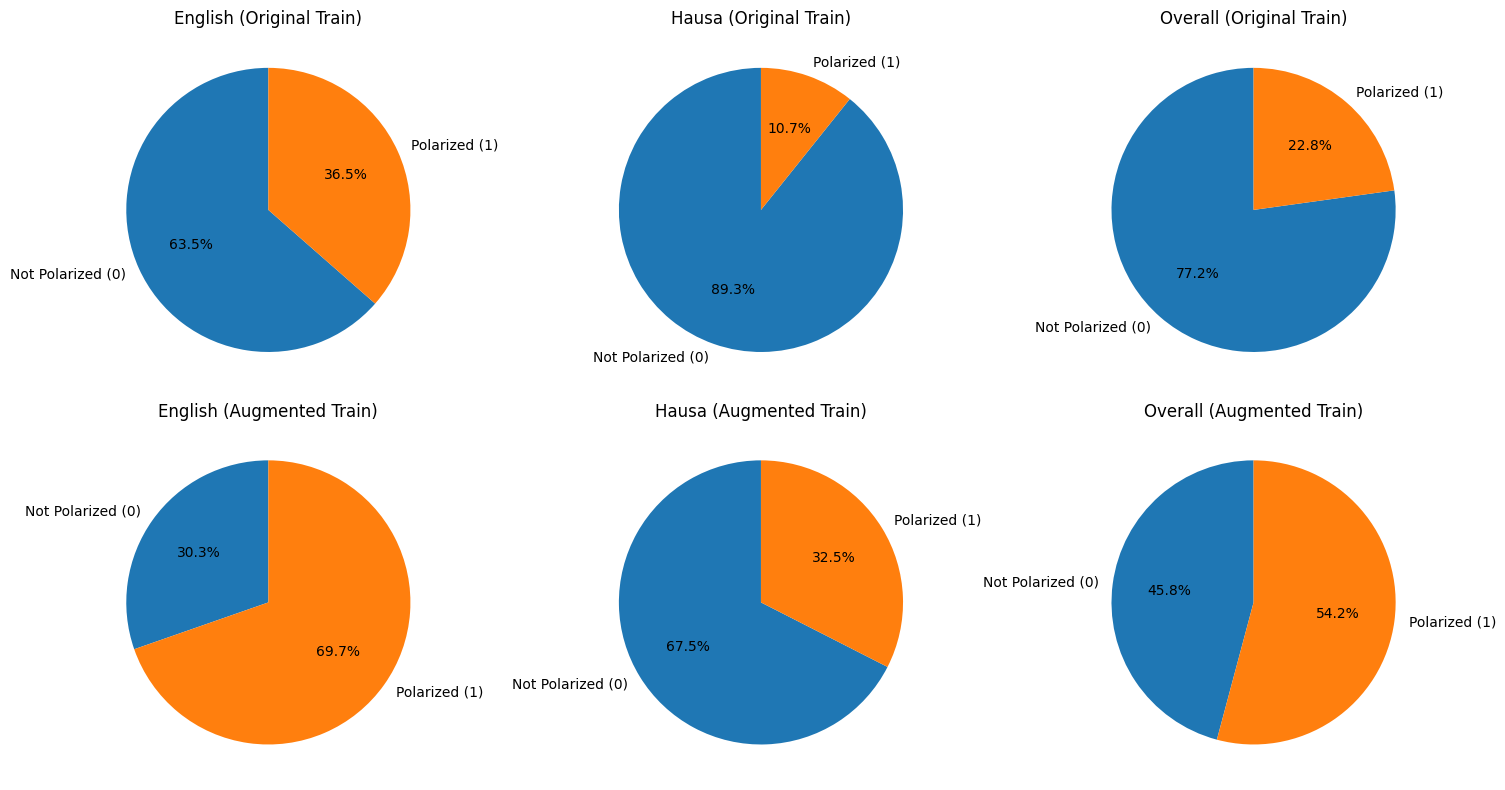

In [18]:
import matplotlib.pyplot as plt

# Compute distributions
dist_eng_orig = train_eng_org['polarization'].value_counts().sort_index()
dist_hau_orig = train_hau_org['polarization'].value_counts().sort_index()

dist_eng_aug = train_eng['polarization'].value_counts().sort_index()
dist_hau_aug = train_hau['polarization'].value_counts().sort_index()

labels = ['Not Polarized (0)', 'Polarized (1)']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# ---------------------
# Original distributions
# ---------------------
axes[0, 0].pie(dist_eng_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Original Train)")

axes[0, 1].pie(dist_hau_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Original Train)")

dist_overall_orig = pd.concat([train_eng_org, train_hau_org], ignore_index=True)['polarization'].value_counts().sort_index()
axes[0, 2].pie(dist_overall_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Original Train)")

# ---------------------
# Augmented distributions
# ---------------------
axes[1, 0].pie(dist_eng_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (Augmented Train)")

axes[1, 1].pie(dist_hau_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (Augmented Train)")

dist_overall_aug = pd.concat([train_eng, train_hau], ignore_index=True)['polarization'].value_counts().sort_index()
axes[1, 2].pie(dist_overall_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (Augmented Train)")

plt.tight_layout()
naming='BERT Base Cased Aug T1 data'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()


### **1.3 Dataset**


##### ***1.3.1 Labelled Dataset***

In [19]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_T1(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

##### ***1.3.2 Unlabelled Dataset***

In [20]:
class Unlabelled_PolarizationDataset_T1(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=[0 for  l in labels]
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

#### **1.3.3 Tokenization**

In [21]:
# Load the tokenizer
tokenizer_task1 = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

#making data_sets
train_dataset_t1 = PolarizationDataset_T1(train['text'].tolist(), train['polarization'].tolist(), tokenizer_task1)
val_dataset_t1 = PolarizationDataset_T1(val['text'].tolist(), val['polarization'].tolist(), tokenizer_task1)


dev_dataset_eng_t1 = Unlabelled_PolarizationDataset_T1(dev_set_eng['text'].tolist(), dev_set_eng['polarization'].tolist(), tokenizer_task1)
dev_dataset_hau_t1 = Unlabelled_PolarizationDataset_T1(dev_set_hau['text'].tolist(), dev_set_hau['polarization'].tolist(), tokenizer_task1)




tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### **1.4 Model Training**

#### **1.4.1 Model Initialization**

In [22]:
model_task1 = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-cased', num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **1.4.2 Metrics Function**

In [23]:
# function to compute metrics
def compute_custom_metrics_task1(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision_macro = precision_score(labels, preds, average='macro', zero_division=0)
    recall_macro = recall_score(labels, preds, average='macro', zero_division=0)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
    f1_micro = f1_score(labels, preds, average='micro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }


#### **1.4.3  Model Parameters**

In [24]:
# Define training arguments
training_args_t1 = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=4,
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        seed=42,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )


#### **1.4.4 Model Trainer**

In [25]:
# Initialize the Trainer
trainer_task1 = Trainer(
    model=model_task1,                       # the instantiated 🤗 Transformers model to be trained
    args=training_args_t1,                  # training arguments, defined above
    train_dataset=train_dataset_t1,         # training dataset
    eval_dataset=val_dataset_t1,            # evaluation dataset
    compute_metrics=compute_custom_metrics_task1,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer_task1) # Data collator for dynamic padding
)

# Train the model
trainer_task1.train()

# Evaluate the model on the validation set
eval_results = trainer_task1.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Micro
1,0.282000,0.554001,0.817126,0.742027,0.762601,0.751032,0.817126
2,0.194000,0.647393,0.854862,0.797453,0.778058,0.786951,0.854862
3,0.115200,0.756983,0.863570,0.817629,0.774717,0.792624,0.863570
4,0.035800,0.908327,0.862119,0.806671,0.793981,0.799994,0.862119


Macro F1 score on validation set: 0.7999938887445954


#### **1.4.6 Test on dev set**

In [26]:
pred_data_t1 = {
    "eng": {'data': dev_dataset_eng_t1, 'ids': dev_set_eng['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t1, 'ids': dev_set_hau['id'].tolist()},
}

for lang in pred_data_t1:
    pred_dev=trainer_task1.predict(pred_data_t1[lang]['data'])
    y_pred = np.argmax(pred_dev.predictions, axis=1)
    y_true = pred_dev.label_ids
    pred_data_t1[lang]['results']=y_pred

#### **1.4.7 Making Submission Package**

In [27]:
# --- Helper: Save a single prediction CSV ---
def save_prediction_csv(df: pd.DataFrame, lang_code: str, folder: str):
    """Save a DataFrame as a csv."""
    file_path = os.path.join(folder, f"pred_{lang_code}.csv")
    df.to_csv(file_path, index=False)
    return file_path

# --- Helper: Zip a folder ---
def zip_folder(folder_path: str, zip_path: str):
    """Create a zip file of the folder."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# --- Main function: Create submission zip ---
def create_submission_zip(task,predictions: Dict[str, pd.DataFrame], output_dir=".",):
    """
    function to create submission zip for Subtask.
    """
    zip_name=f"{task}.zip"
    # Folder for submission files
    submission_folder = os.path.join(output_dir, task)
    os.makedirs(submission_folder, exist_ok=True)

    # Save each prediction CSV
    for lang_code, df in predictions.items():
        save_prediction_csv(df, lang_code, submission_folder)

    # Create zip
    zip_path = os.path.join(output_dir, zip_name)
    zip_folder(submission_folder, zip_path)
    print(f"Submission zip created at: {zip_path}")


In [28]:
submission_dict = {}

for lang in pred_data_t1:
    df = pd.DataFrame({
        "id": pred_data_t1[lang]['ids'],
        "polarization": pred_data_t1[lang]['results']
    })
    submission_dict[lang] = df

create_submission_zip('subtask_1',submission_dict)

Submission zip created at: ./subtask_1.zip


#### **1.4.8 Saving the Model**

In [29]:
from datetime import datetime

In [30]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='BERT Base Cased Aug'
save_path = f"saved_model_aug_t1_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task1.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

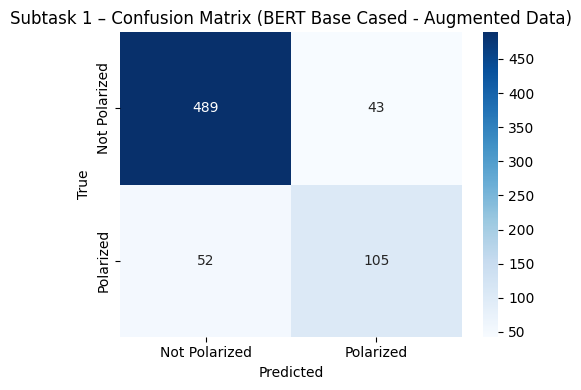

In [31]:
# Get predictions on validation set
val_preds_t1 = trainer_task1.predict(val_dataset_t1)

y_true_t1 = val_preds_t1.label_ids
y_pred_t1 = np.argmax(val_preds_t1.predictions, axis=1)

# Confusion matrix
cm_t1 = confusion_matrix(y_true_t1, y_pred_t1)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_t1,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Polarized", "Polarized"],
    yticklabels=["Not Polarized", "Polarized"]
)
naming='BERT Base Cased - Augmented Data'
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Subtask 1 – Confusion Matrix ({naming})")
plt.savefig(f'drive/MyDrive/NLP/{naming}_t1.pdf',format='pdf',dpi=300)
plt.tight_layout()
plt.show()

# **2.Subtask 2: Polarization Type Classification**

### **2.1 Data Import**

#### **Data Augmentation Functions**

In [32]:
def augment_multilabel_backtranslation(
    df,
    text_col,
    label_cols,
    translate_fn,
    device='cpu',
    rare_label_threshold=0.15,
    n_augments=2,
    batch_size=16,
    lang='English'
):
    """
    Back-translation augmentation for multi-label datasets.
    Augments only samples containing rare labels.
    """

    #Computing label frequencies
    label_freq = df[label_cols].mean()
    rare_labels = label_freq[label_freq < rare_label_threshold].index.tolist()

    print(f"[{lang}] Rare labels:", rare_labels)

    #Selecting rows containing at least one rare label
    mask = df[rare_labels].sum(axis=1) > 0
    target_df = df[mask].copy()

    print(f"[{lang}] Samples selected for augmentation: {len(target_df)}")

    if len(target_df) == 0:
        return df

    augmented_rows = []
    texts = target_df[text_col].tolist()
    total_batches = math.ceil(len(texts) / batch_size)

    for batch_idx in tqdm(range(total_batches), desc=f"Back-translating ({lang})"):
        batch_texts = texts[batch_idx*batch_size:(batch_idx+1)*batch_size]

        for _ in range(n_augments):
            augmented_texts = translate_fn(batch_texts, device=device)

            for i, aug_text in enumerate(augmented_texts):
                row = target_df.iloc[batch_idx*batch_size + i].copy()
                row[text_col] = aug_text
                augmented_rows.append(row)

    augmented_df = pd.DataFrame(augmented_rows)

    #Merge & shuffle
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)
    df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_augmented

#### **Data Train Split and Augumentation**

In [33]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def multilabel_split(df, labels, test_size=0.1, seed=40):
    splitter = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=seed
    )
    X = df.index.values
    y = df[labels].values

    for train_idx, val_idx in splitter.split(X, y):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

    return train_df, val_df

In [34]:

train_eng_all_t2 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/eng.csv')
train_hau_all_t2 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/hau.csv')

labels = ['gender/sexual','political','religious','racial/ethnic','other']

train_eng_org_t2, val_eng = multilabel_split(train_eng_all_t2, labels)
train_hau_org_t2, val_hau = multilabel_split(train_hau_all_t2, labels)

train_eng_t2 = augment_multilabel_backtranslation(
    train_eng_org_t2,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_en,
    device=device,
    rare_label_threshold=0.20,
    n_augments=2,
    batch_size=16,
    lang='English'
)

train_hau_t2 = augment_multilabel_backtranslation(
    train_hau_org_t2,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_hausa,
    device=device,
    rare_label_threshold=0.20,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)



train_t2 = pd.concat([train_eng_t2, train_hau_t2], ignore_index=True)
val_t2 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/eng.csv')
dev_set_hau_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/hau.csv')

train_t2.head()

[English] Rare labels: ['gender/sexual', 'religious', 'racial/ethnic', 'other']
[English] Samples selected for augmentation: 404


Back-translating (English): 100%|██████████| 26/26 [01:03<00:00,  2.45s/it]


[Hausa] Rare labels: ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']
[Hausa] Samples selected for augmentation: 354


Back-translating (Hausa): 100%|██████████| 23/23 [02:15<00:00,  5.87s/it]


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_abf4d40839816e0abe3f44e7ee75fe6e,"Its essentially ""inspired flight"" but with a s...",1,1,0,0,0
1,eng_c3fd7dbb83cf061b5cc4c34b5f1c3ad6,Ukraine remains resilient in the face of Russi...,0,0,0,0,0
2,eng_90a6d5ae4b31bed1a5b8b4b7b997438f,Where did all the proPalestine antigenocide pe...,1,0,0,0,0
3,eng_f0d5e316b37b7c87bb5e1f55582b9da8,PBPD Officer Retires After 33-Year Career,0,0,0,0,0
4,eng_dc569943086027fdbf85d874f02f6f5a,Police ID Man Killed While Riding Bike,0,0,0,0,0


#### **Data Exploration**

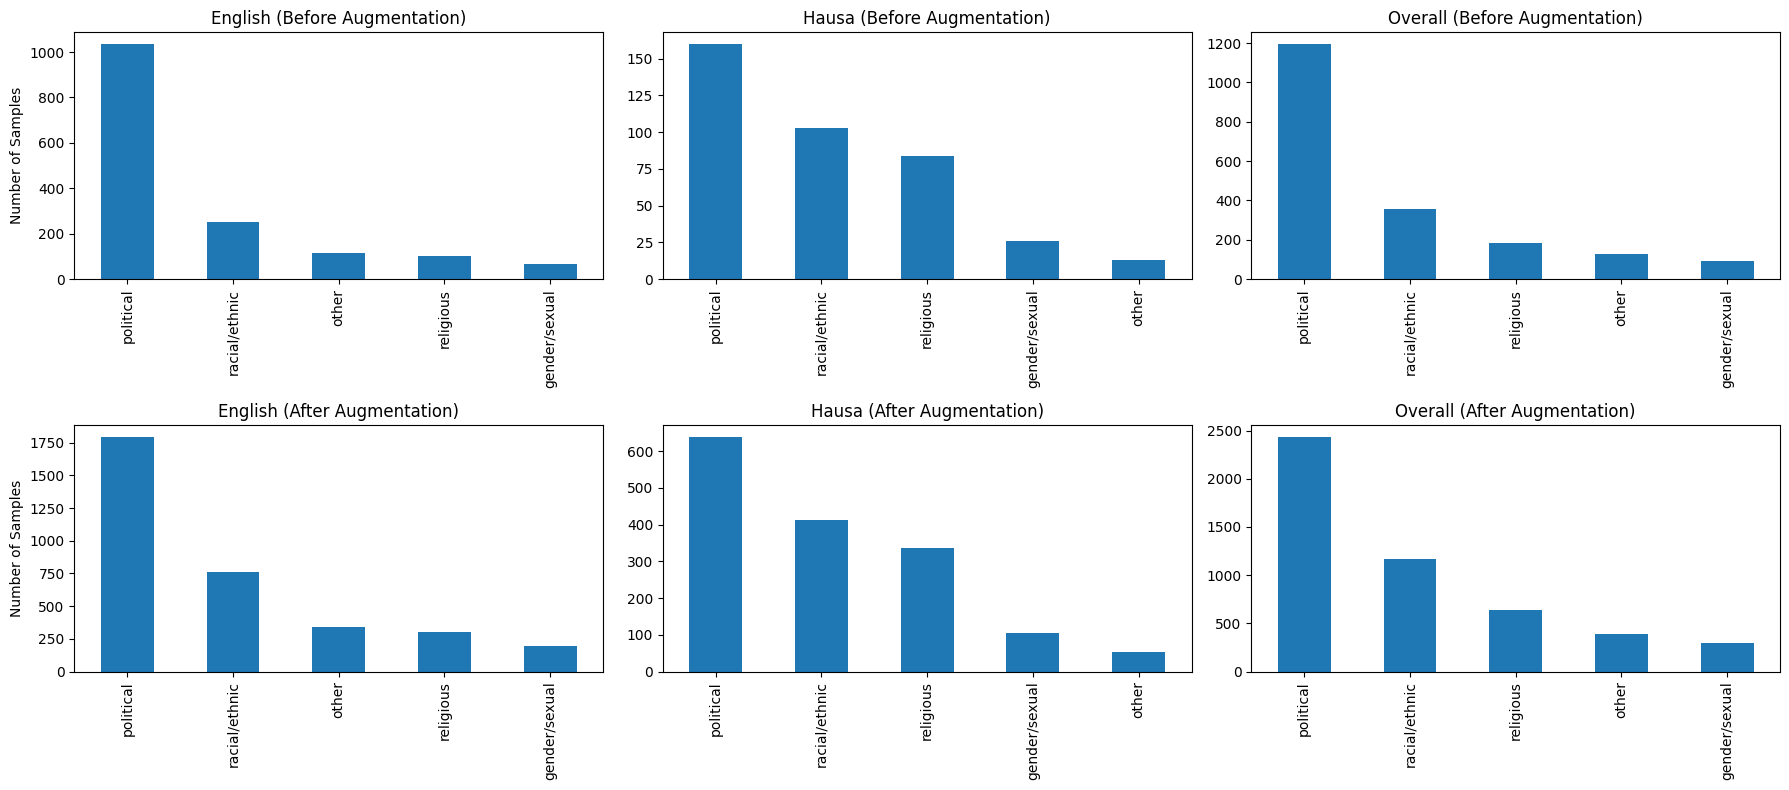

In [35]:
# Label columns
labels = ['gender/sexual','political','religious','racial/ethnic','other']

# BEFORE augmentation
dist_eng_before = train_eng_org_t2[labels].sum().sort_values(ascending=False)
dist_hau_before = train_hau_org_t2[labels].sum().sort_values(ascending=False)

train_t2_before = pd.concat([train_eng_org_t2, train_hau_org_t2], ignore_index=True)
dist_overall_before = train_t2_before[labels].sum().sort_values(ascending=False)

# AFTER augmentation
dist_eng_after = train_eng_t2[labels].sum().sort_values(ascending=False)
dist_hau_after = train_hau_t2[labels].sum().sort_values(ascending=False)
dist_overall_after = train_t2[labels].sum().sort_values(ascending=False)


fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
dist_eng_before.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title("English (Before Augmentation)")
axes[0, 0].set_ylabel("Number of Samples")

dist_hau_before.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Hausa (Before Augmentation)")

dist_overall_before.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
dist_eng_after.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("English (After Augmentation)")
axes[1, 0].set_ylabel("Number of Samples")

dist_hau_after.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Hausa (After Augmentation)")

dist_overall_after.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='BERT Base Cased Aug T2 data bars'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()



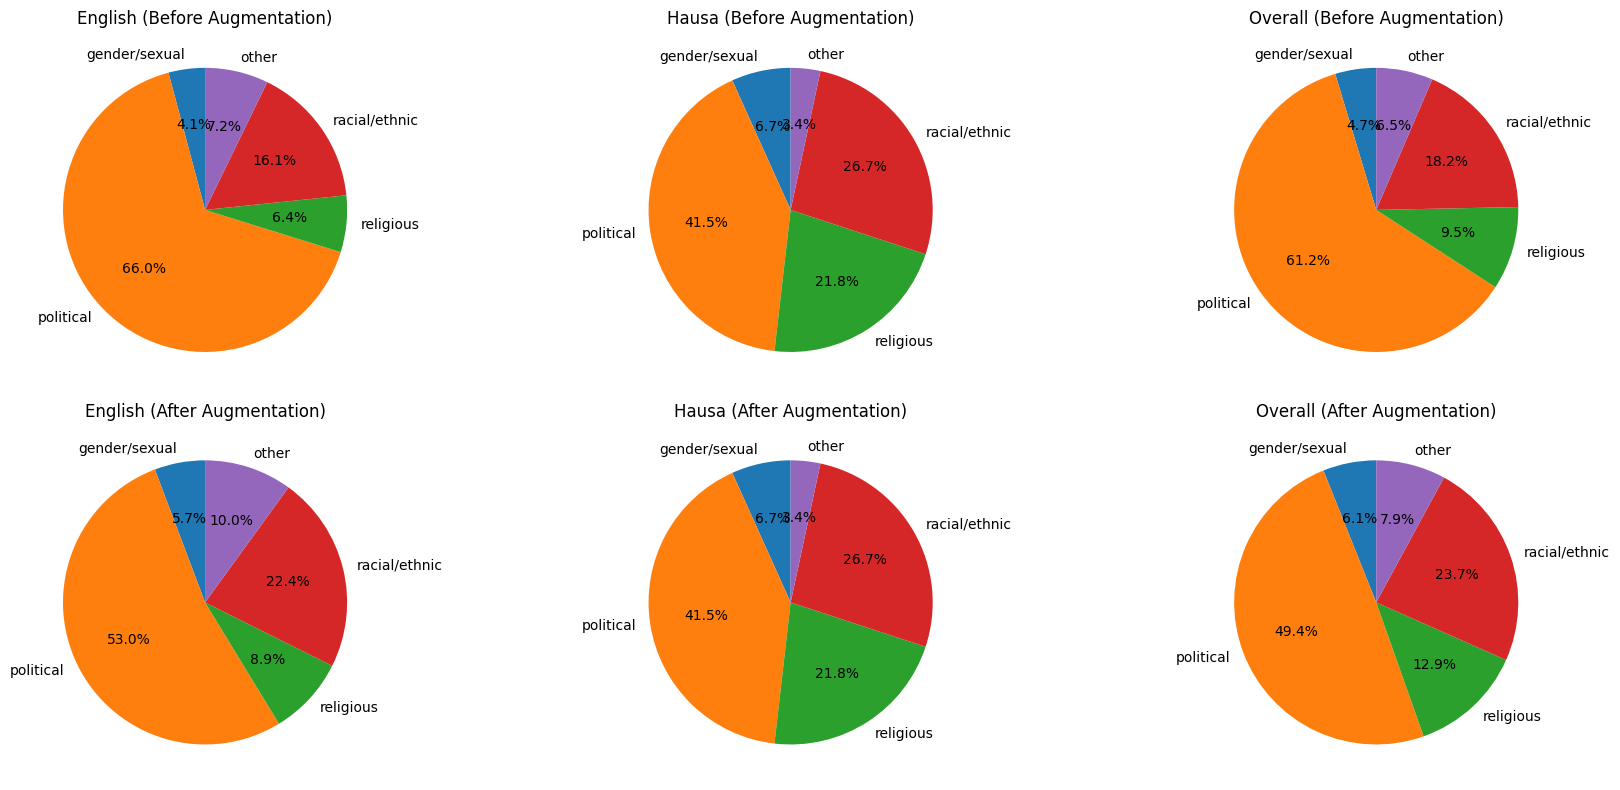

Desired Label Distribution: 20.00% per class


In [36]:
# Label columns
labels = ['gender/sexual','political','religious','racial/ethnic','other']

# BEFORE augmentation
dist_eng_before = train_eng_org_t2[labels].sum()
dist_hau_before = train_hau_org_t2[labels].sum()

train_t2_before = pd.concat([train_eng_org_t2, train_hau_org_t2], ignore_index=True)
dist_overall_before = train_t2_before[labels].sum()

#  AFTER augmentation
dist_eng_after = train_eng_t2[labels].sum()
dist_hau_after = train_hau_t2[labels].sum()
dist_overall_after = train_t2[labels].sum()

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
axes[0, 0].pie(dist_eng_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Before Augmentation)")

axes[0, 1].pie(dist_hau_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Before Augmentation)")

axes[0, 2].pie(dist_overall_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
axes[1, 0].pie(dist_eng_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (After Augmentation)")

axes[1, 1].pie(dist_hau_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (After Augmentation)")

axes[1, 2].pie(dist_overall_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='BERT Base Cased Aug T2 data pie'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()

print(f"Desired Label Distribution: {100/len(labels):.02f}% per class")


### **2.2 Dataset**

#### **2.2.1 Labelled Dataset**

In [37]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_t2(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}

        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


#### **2.2.2 Unlabelled Dataset**

In [38]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class Unlabelled_PolarizationDataset_t2(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [[0, 0, 0, 0, 0] for i in labels]

        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}

        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


#### **2.2.3 Tokenization**

In [39]:
# Load the tokenizer
tokenizer_task2 = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

# Create train and Test dataset for multilabel
train_dataset_t2 = PolarizationDataset_t2(train_t2['text'].tolist(), train_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)
val_dataset_t2 = PolarizationDataset_t2(val_t2['text'].tolist(), val_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)

dev_dataset_eng_t2 = Unlabelled_PolarizationDataset_t2(dev_set_eng_t2['text'].tolist(), dev_set_eng_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)
dev_dataset_hau_t2 = Unlabelled_PolarizationDataset_t2(dev_set_hau_t2['text'].tolist(), dev_set_hau_t2[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer_task2)

### **2.3 Model Training**

#### **2.3.1 Model Initialization**

In [40]:
# Load the model suitabled for  5 labels
model_task2 = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-cased', num_labels=5, problem_type="multi_label_classification")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **2.3.2 Metrics Function**

In [41]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel_task2(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}



#### **2.3.3  Model Parameters**

In [42]:
# Define training arguments
training_args_task2 = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=4,
        learning_rate=4e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        seed=42,
        weight_decay=0.01,
        warmup_ratio=0.1,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False
    )

#### **2.3.4 Model Trainer**

In [43]:
# Initialize the Trainer
trainer_task2 = Trainer(
    model=model_task2,
    args=training_args_task2,
    train_dataset=train_dataset_t2,
    eval_dataset=val_dataset_t2,
    compute_metrics=compute_metrics_multilabel_task2,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer_task2)
)

# Train the model
trainer_task2 .train()

# Evaluate the model on the validation set
eval_results = trainer_task2 .evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.217500,0.152972,0.295500
2,0.129400,0.154247,0.312074
3,0.058500,0.177824,0.361463
4,0.030800,0.183755,0.339309


Macro F1 score on validation set for Subtask 2: 0.33930894002521794


#### **2.3.5 Test on dev set**

In [44]:
from scipy.special import expit

In [45]:
pred_data_t2 = {
    "eng": {'data': dev_dataset_eng_t2, 'ids': dev_set_eng_t2['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t2, 'ids': dev_set_hau_t2['id'].tolist()},
}

for lang in pred_data_t2:
    pred_dev=trainer_task2.predict(pred_data_t2[lang]['data'])

    #converting logits to probabilities using sigmoid
    probs = expit(pred_dev.predictions)

    y_pred = (probs > 0.5).astype(int)

    y_true = pred_dev.label_ids
    pred_data_t2[lang]['results']=y_pred



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **2.3.6 Making Submission Package**

In [46]:
submission_dict = {}

for lang in pred_data_t2:
    df = pd.DataFrame({
        "id": pred_data_t2[lang]['ids'],
        'gender/sexual':pred_data_t2[lang]['results'][:,0],
        'political':pred_data_t2[lang]['results'][:,1],
        'religious':pred_data_t2[lang]['results'][:,2],
        'racial/ethnic':pred_data_t2[lang]['results'][:,3],
        'other':pred_data_t2[lang]['results'][:,4]
    })
    submission_dict[lang] = df

create_submission_zip('subtask_2',submission_dict)

Submission zip created at: ./subtask_2.zip


#### **2.3.7 Saving the Model**

In [47]:
from datetime import datetime

In [48]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='BERT Base Cased Base Aug'
save_path = f"saved_model_aug_t2_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task2.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

In [49]:
def plot_label_confusion_matrix_multilabel(
    y_true,
    y_pred,
    label_names,
    naming,
    title
):
    n_labels = len(label_names)
    matrix = np.zeros((n_labels, n_labels), dtype=int)

    for i in range(n_labels):
        for j in range(n_labels):
            matrix[i, j] = np.sum(
                (y_true[:, i] == 1) & (y_pred[:, j] == 1)
            )

    plt.figure(figsize=(7,6))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
    plt.tight_layout()
    plt.show()


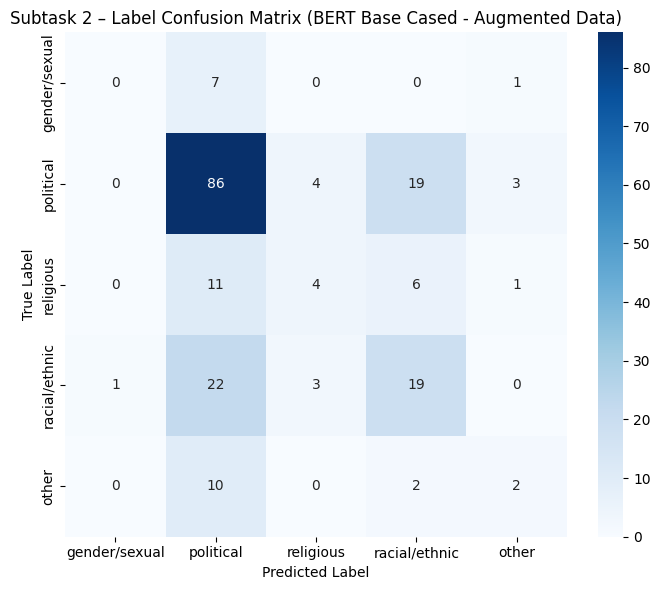

In [50]:
# Validation predictions
val_preds_t2 = trainer_task2.predict(val_dataset_t2)

# Sigmoid + threshold
probs_t2 = torch.sigmoid(torch.from_numpy(val_preds_t2.predictions))
y_pred_t2 = (probs_t2 > 0.5).int().numpy()
y_true_t2 = val_preds_t2.label_ids

labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']
naming='BERT Base Cased - Augmented Data_t2'
title='BERT Base Cased - Augmented Data'
plot_label_confusion_matrix_multilabel(
    y_true_t2,
    y_pred_t2,
    labels_t2,
    naming,
    title=f"Subtask 2 – Label Confusion Matrix ({title})"
)


# **3.Subtask 3: Manifestation Identification**



### **3.1 Data Import**

#### **Data Train Split and Augumentation**

In [52]:
# Labels
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']
train_eng_org_all_t3 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/eng.csv')
train_hau_org_all_t3 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/hau.csv')

train_eng_org_t3, val_eng = multilabel_split(train_eng_org_all_t3, labels)
train_hau_org_t3, val_hau = multilabel_split(train_hau_org_all_t3, labels)

train_eng_3 = augment_multilabel_backtranslation(
    train_eng_org_t3,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_en,
    device=device,
    rare_label_threshold=0.16,
    n_augments=2,
    batch_size=16,
    lang='English'
)

train_hau_t3 = augment_multilabel_backtranslation(
    train_hau_org_t3,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_hausa,
    device=device,
    rare_label_threshold=0.16,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)



train_t3 = pd.concat([train_eng_t3, train_hau_t3], ignore_index=True)
val_t3 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/eng.csv')
dev_set_hau_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/hau.csv')


train_t3.head()

[English] Rare labels: ['stereotype', 'dehumanization', 'lack_of_empathy']
[English] Samples selected for augmentation: 721


Back-translating (English): 100%|██████████| 46/46 [01:58<00:00,  2.58s/it]


[Hausa] Rare labels: ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']
[Hausa] Samples selected for augmentation: 354


Back-translating (Hausa): 100%|██████████| 23/23 [02:23<00:00,  6.23s/it]


,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,0


#### **Data Exploration**

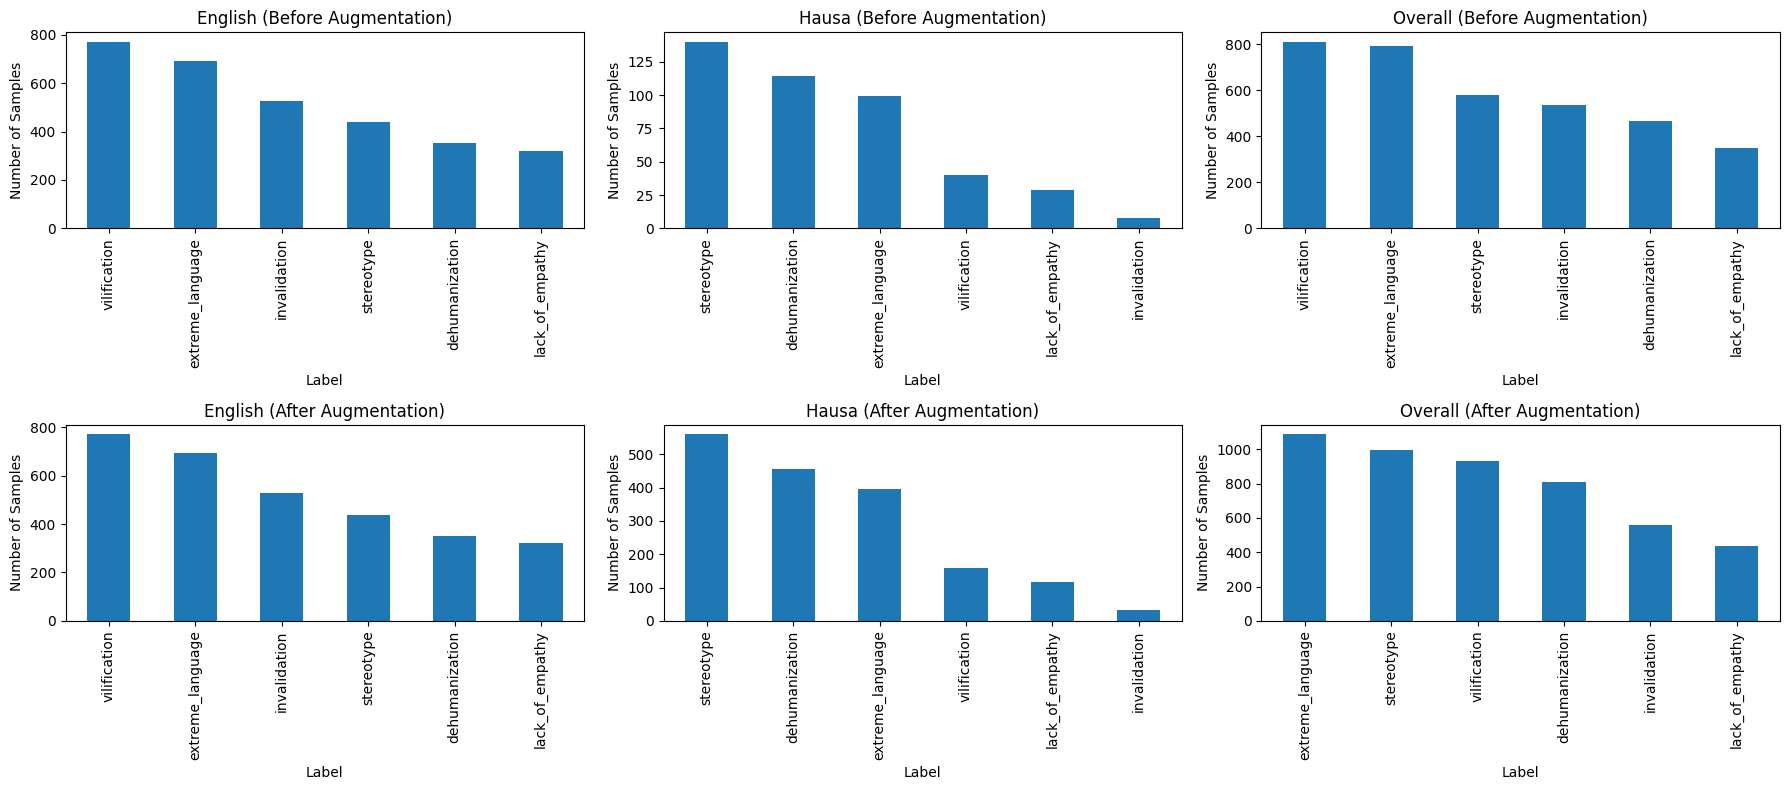

In [53]:
# Label columns
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']

# BEFORE augmentation
dist_eng_before = train_eng_org_t3[labels].sum().sort_values(ascending=False)
dist_hau_before = train_hau_org_t3[labels].sum().sort_values(ascending=False)

train_t3_before = pd.concat([train_eng_org_t3, train_hau_org_t3], ignore_index=True)
dist_overall_before = train_t3_before[labels].sum().sort_values(ascending=False)

# AFTER augmentation
dist_eng_after = train_eng_t3[labels].sum().sort_values(ascending=False)
dist_hau_after = train_hau_t3[labels].sum().sort_values(ascending=False)
dist_overall_after = train_t3[labels].sum().sort_values(ascending=False)

#  Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
dist_eng_before.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title("English (Before Augmentation)")
axes[0, 0].set_ylabel("Number of Samples")
axes[0, 0].set_xlabel("Label")

dist_hau_before.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Hausa (Before Augmentation)")
axes[0, 1].set_ylabel("Number of Samples")
axes[0, 1].set_xlabel("Label")

dist_overall_before.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title("Overall (Before Augmentation)")
axes[0, 2].set_ylabel("Number of Samples")
axes[0, 2].set_xlabel("Label")

# Row 2 — AFTER
dist_eng_after.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("English (After Augmentation)")
axes[1, 0].set_ylabel("Number of Samples")
axes[1, 0].set_xlabel("Label")

dist_hau_after.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Hausa (After Augmentation)")
axes[1, 1].set_ylabel("Number of Samples")
axes[1, 1].set_xlabel("Label")

dist_overall_after.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title("Overall (After Augmentation)")
axes[1, 2].set_ylabel("Number of Samples")
axes[1, 2].set_xlabel("Label")

plt.tight_layout()
naming='BERT Base Cased Aug T3 data bars'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()


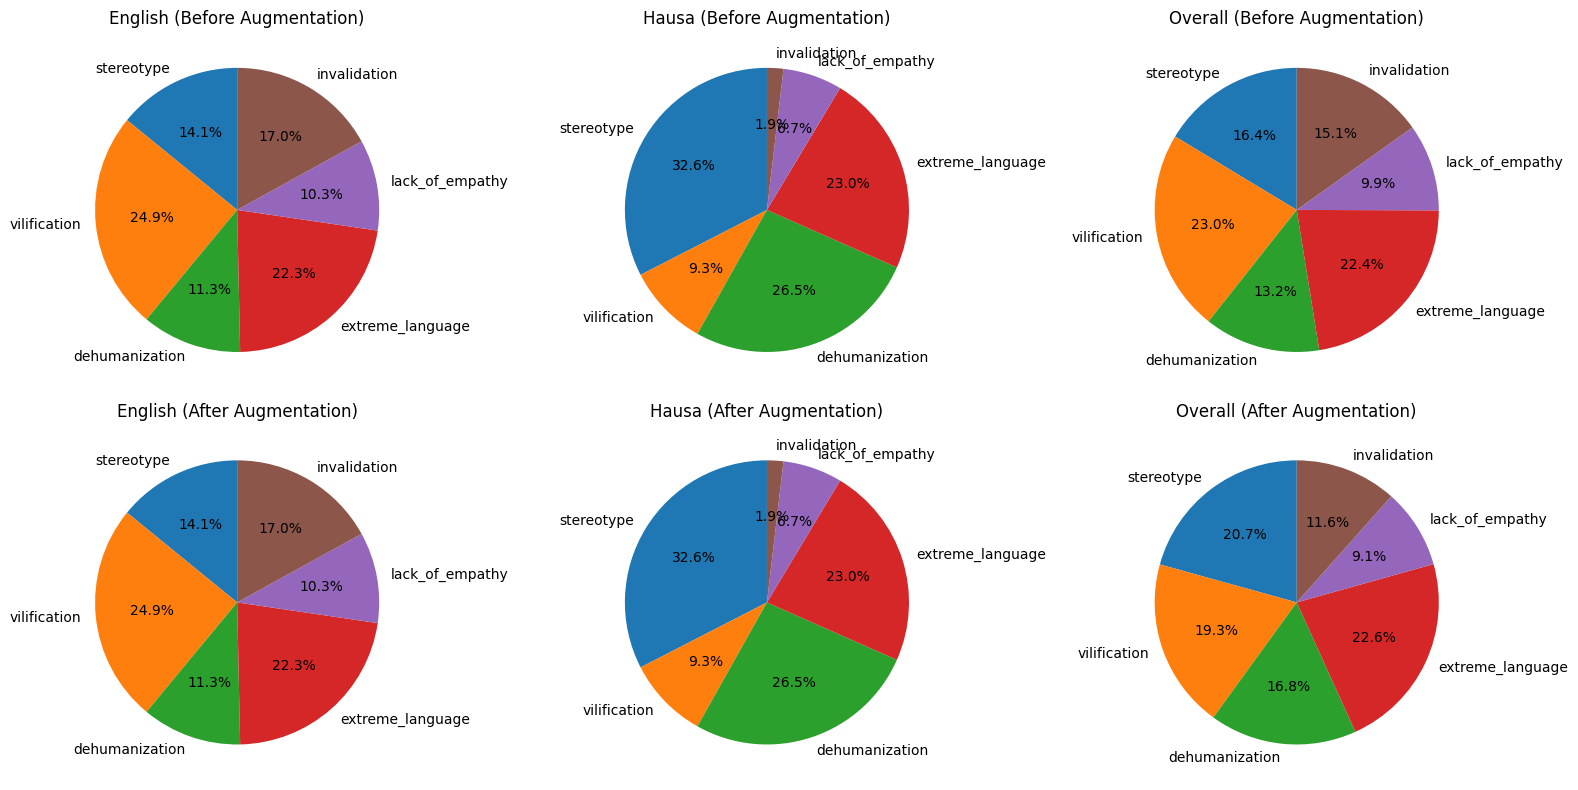

Desired Label Distribution (Uniform): 16.67%


In [54]:
# Label columns
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']

#  BEFORE augmentation
dist_eng_before = train_eng_org_t3[labels].sum()
dist_hau_before = train_hau_org_t3[labels].sum()

train_t3_before = pd.concat([train_eng_org_t3, train_hau_org_t3], ignore_index=True)
dist_overall_before = train_t3_before[labels].sum()

# AFTER augmentation
dist_eng_after = train_eng_t3[labels].sum()
dist_hau_after = train_hau_t3[labels].sum()
dist_overall_after = train_t3[labels].sum()


fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Row 1 — BEFORE
axes[0, 0].pie(dist_eng_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Before Augmentation)")

axes[0, 1].pie(dist_hau_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Before Augmentation)")

axes[0, 2].pie(dist_overall_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
axes[1, 0].pie(dist_eng_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (After Augmentation)")

axes[1, 1].pie(dist_hau_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (After Augmentation)")

axes[1, 2].pie(dist_overall_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='BERT Base Cased Aug T3 data pie'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()

print(f"Desired Label Distribution (Uniform): {100/len(labels):.2f}%")


### **3.2 Dataset**

#### **3.2.1 Labelled Dataset**

In [55]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset_t3(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

#### **3.2.1 UnLabelled Dataset**

In [56]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class UnlabelledPolarizationDataset_t3(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = [[0,0,0,0,0,0] for i in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

#### **3.2.2 Tokenization**

In [57]:
# Load the tokenizer
tokenizer_task3 = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

# Create train and Test dataset for multilabel
train_dataset_t3 = PolarizationDataset_t3(train_t3['text'].tolist(), train_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)
val_dataset_t3 = PolarizationDataset_t3(val_t3['text'].tolist(), val_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)

dev_dataset_eng_t3 = UnlabelledPolarizationDataset_t3(dev_set_eng_t3['text'].tolist(), dev_set_eng_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)
dev_dataset_hau_t3 = UnlabelledPolarizationDataset_t3(dev_set_hau_t3['text'].tolist(), dev_set_hau_t3[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer_task3)

### **3.3 Model Training**

#### **3.3.1 Model Initialization**

In [58]:
# Load the model
model_task3 = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-cased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **3.3.2 Metrics Function**

In [59]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel_task3(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

#### **3.3.3  Model Parameters**

In [60]:
# Define training arguments
training_args_t3 = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=6,
    learning_rate=4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)



#### **3.3.4 Model Trainer**

In [61]:
# Initialize the Trainer
trainer_task3 = Trainer(
    model=model_task3,
    args=training_args_t3,
    train_dataset=train_dataset_t3,
    eval_dataset=val_dataset_t3,
    compute_metrics=compute_metrics_multilabel_task3,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer_task3)
)

# Train the model
trainer_task3.train()

# Evaluate the model on the validation set
eval_results = trainer_task3.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.253700,0.229403,0.081585
2,0.219600,0.249135,0.155052
3,0.183300,0.280665,0.362846
4,0.133300,0.275800,0.312558
5,0.095600,0.305746,0.321138
6,0.064900,0.327109,0.299170


Macro F1 score on validation set for Subtask 3: 0.2991700257490238


#### **3.3.5 Test on dev set**

In [62]:
from scipy.special import expit

In [63]:
pred_data_t3 = {
    "eng": {'data': dev_dataset_eng_t3, 'ids': dev_set_eng_t3['id'].tolist()},
    "hau": {'data': dev_dataset_hau_t3, 'ids': dev_set_hau_t3['id'].tolist()},
}

for lang in pred_data_t3:
    pred_dev=trainer_task3.predict(pred_data_t3[lang]['data'])

    #converting logits to probabilities using sigmoid
    probs = expit(pred_dev.predictions)

    y_pred = (probs > 0.5).astype(int)

    y_true = pred_dev.label_ids
    pred_data_t3[lang]['results']=y_pred



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **3.3.5 Making Submission Package**

In [64]:
submission_dict = {}

for lang in pred_data_t3:
    df = pd.DataFrame({
        "id": pred_data_t3[lang]['ids'],
        'vilification':pred_data_t3[lang]['results'][:,0],
        'extreme_language':pred_data_t3[lang]['results'][:,1],
        'stereotype':pred_data_t3[lang]['results'][:,2],
        'invalidation':pred_data_t3[lang]['results'][:,3],
        'lack_of_empathy':pred_data_t3[lang]['results'][:,4],
        'dehumanization':pred_data_t3[lang]['results'][:,5]
    })
    submission_dict[lang] = df

create_submission_zip('subtask_3',submission_dict)

Submission zip created at: ./subtask_3.zip


#### **3.3.6 Saving the Model**

In [65]:
from datetime import datetime

In [66]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='BERT Base Cased Aug'
save_path = f"saved_model_aug_t3_{naming}_f1_{eval_results['eval_f1_macro']:.4f}_{timestamp}"
trainer_task3.save_model('drive/MyDrive/NLP/models'+'//'+save_path)

### **Confusion Matrix**

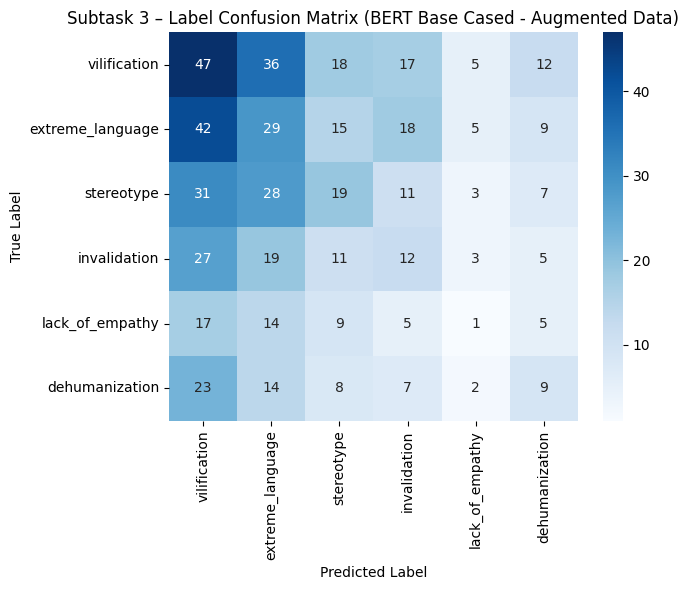

In [67]:
# Validation predictions
val_preds_t3 = trainer_task3.predict(val_dataset_t3)

# Sigmoid + threshold
probs_t3 = torch.sigmoid(torch.from_numpy(val_preds_t3.predictions))
y_pred_t3 = (probs_t3 > 0.5).int().numpy()
y_true_t3 = val_preds_t3.label_ids

labels_t3 = [
    'vilification',
    'extreme_language',
    'stereotype',
    'invalidation',
    'lack_of_empathy',
    'dehumanization'
]
naming='BERT Base Cased - Augmented Data_t3'
title='BERT Base Cased - Augmented Data'
plot_label_confusion_matrix_multilabel(
    y_true_t3,
    y_pred_t3,
    labels_t3,
    naming,
    title=f"Subtask 3 – Label Confusion Matrix ({title})"
)
